<a href="https://colab.research.google.com/github/surasakcho/A_A/blob/master/01_00_3_LS8_download_cloud_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Bulk Downloads of Landsat-8 Data Products in Python

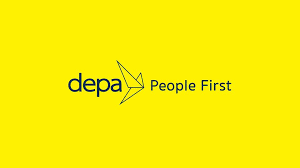

![](https://s3.amazonaws.com/thinkific-import/85575/d8MJIPrSQadxUEbtVj7c_Screen%20Shot%202017-10-16%20at%2001.02.07.png)

In [0]:
## For PIER's PC ##

#conda install -c conda-forge folium
#conda install -c conda-forge cartopy

# Install libraries & Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install rasterio
!pip install geopandas
!pip install rio-toa --quiet
!pip install rio-l8qa --quiet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 232 kB in 1s (308 kB/s)
Selecting previously unselected package libproj-dev:amd64.
(Reading database ... 133872 files and directories currently installed.)
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-2) ...
Selecting previously unselected package proj-bin.
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.

# Import libraries

In [0]:
import pandas as pd
import geopandas as gpd
import folium
import os, shutil
from glob import glob
import re
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

import requests
from bs4 import BeautifulSoup
import re
import os
from l8qa.qa import write_cloud_mask
from rio_toa import reflectance

from datetime import datetime
import pytz

from tqdm import tqdm_notebook

import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Define parameters & paths

In [0]:
creation_options = {'nodata': 0,
                    'compress': 'deflate',
                    'predict': 2}

processes = 4
rescale_factor = 1
dtype = 'float'

LANDSAT_TEMP_PATH = "./"

my_drive_path = "/content/drive/My Drive/"

landsat_output_path = os.path.join(my_drive_path, '!landsat8-prep')
os.makedirs(landsat_output_path, exist_ok=True)

temp_path = os.path.join(landsat_output_path, 'temp')
os.makedirs(temp_path, exist_ok=True)

ls8_cloudmask_output_path = os.path.join(landsat_output_path, 'cloudmask')
os.makedirs(ls8_cloudmask_output_path, exist_ok=True)

# Define functions

## list_files_re

In [0]:

def list_files_re(rootpath, filename_re=None, folder_re=None ):
    '''
    rootpath : root path to lookup files
    filename_re : regular expression to search for filename
    folder_re : regular expression to search for folder

    return : a list of filepaths
    '''


    list_files = []
    for folder, _, files in os.walk(rootpath):
        for file in files:     
            if filename_re == None:
                filename_re = '.*'
            if folder_re == None:
                folder_re = '.*'
                
            if ((re.search(filename_re, file) != None) & (re.search(folder_re, folder) != None)):
                list_files.append(os.path.join(folder, file))
        
    return list_files    
        
        
    

## download_landsat_for_ndvi

In [0]:
def download_landsat_for_cloudmask(product_folder, download_url, if_exists='skip', target_file_tps=['QA']):
    dict_file_save_path = {}
    response = requests.get(download_url)
    file_tp = ''
    # If the response status code is fine (200)
    if response.status_code == 200:
        
        # Import the html to beautiful soup
        html = BeautifulSoup(response.content, 'html.parser')
        
        # Create the dir where we will put this image files.
        
        os.makedirs(product_folder, exist_ok=True)
        
        # Second loop: for each band of this image that we find using the html <li> tag
        for li in html.find_all('li'):
            
            # Get the href tag
            file = li.find_next('a').get('href')
            if file.endswith('QA.TIF'):
                file_tp = 'QA'   
            else:
                file_tp = 'OTHER'

            # Download the files            
            file_save_path = os.path.join(product_folder, file)
                          
            if file_tp not in target_file_tps and target_file_tps != 'all':               
                continue

            dict_file_save_path[file_tp] = file_save_path
            if if_exists == 'skip' and os.path.exists(file_save_path):
                print(f'File {file} already exists. Skip downloading this file.')
                continue
            else:
                print('Downloading: {}'.format(file))
                response = requests.get(download_url.replace('index.html', file), stream=True)

                with open(file_save_path, 'wb') as output:
                    shutil.copyfileobj(response.raw, output)
                del response
        

        return list(dict_file_save_path.values())

## create_cloud_mask

In [0]:
def create_cloud_mask(product_folder):
    list_files = list_files_re(product_folder, 'QA.TIF')

    qa_file_path = list_files[0]
    #'LC08_L1GT_126049_20170613_20170613_01_RT_BQA.TIF'
    qa_file_name = os.path.basename(qa_file_path)

    scene_id = qa_file_name.split('_')[2]
    img_date = qa_file_name.split('_')[3]
    with rasterio.open(qa_file_path) as qa_raster:
        # Update the raster profile to use 0 as 'nodata'
        profile = qa_raster.profile
        profile.update(nodata=0)

        #Call `write_cloud_mask` to create a mask where the QA points to clouds.
        out_path = os.path.join(ls8_cloudmask_output_path, f'cloudmask_{scene_id}_{img_date}.TIF')
        if ~os.path.exists(out_path):
           write_cloud_mask(qa_raster.read(1), profile, out_path)
        #print('Cloudmask')
        #plot.show(rasterio.open(os.path.join(product_folder, 'cloudmask.TIF')))
        

## update_log

In [0]:
def update_log(output_filename, status):
    with open(os.path.join(ls8_cloudmask_output_path, 'log.txt'), 'a') as f:
        curr_dttm = datetime.now(pytz.timezone('Asia/Bangkok'))
        curr_dttm = f'{curr_dttm}'[:19]
        f.write(f'{output_filename},{curr_dttm},{status}\n')


# Execute

### Download scenes list

In [0]:
try:
    s3_scenes = pd.read_csv(os.path.join(landsat_output_path, 's3_scenes.csv'))
except:
    s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')    

    s3_scenes['date'] = s3_scenes['acquisitionDate'].str.slice(0,10).str.replace('-','')
    s3_scenes['yyyymm'] = s3_scenes['acquisitionDate'].str.slice(0,7).str.replace('-','')
    s3_scenes['year'] = s3_scenes['acquisitionDate'].str.slice(0,4).str.replace('-','')
    s3_scenes['path_row'] = s3_scenes['path'].astype(str) + s3_scenes['row'].astype(str).apply(lambda x: x.zfill(3))

    df_thailand_path_row = pd.read_csv(os.path.join(landsat_output_path, 'landsat_thailand_path_row.csv'))
    df_thailand_path_row['path_row'] = df_thailand_path_row['PATH'].astype(str) + df_thailand_path_row['ROW'].astype(str).apply(lambda x: x.zfill(3))
    
    s3_scenes = s3_scenes[s3_scenes['path_row'].isin(df_thailand_path_row['path_row'])]

    s3_scenes['output_filename'] = 'ls8_' + s3_scenes['path_row'] + '_' + s3_scenes['date'] + '.tif'
    
    #drop same image having more than one version of file (RT/T1/T2) keep the latest release version
    s3_scenes = s3_scenes.sort_values('productId').drop_duplicates(subset='output_filename', keep='last')

    s3_scenes.to_csv(os.path.join(landsat_output_path, 's3_scenes.csv'), index=False)
# google_scenes = pd.read_csv('https://storage.googleapis.com/gcp-public-data-landsat/index.csv.gz', compression='gzip')

In [12]:
s3_scenes['download_url'].iloc[0]

'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/126/049/LC08_L1GT_126049_20170613_20170613_01_RT/index.html'

### Select only non-existing target images 

In [0]:
list_exist_files = list_files_re(ls8_cloudmask_output_path, '.tif')
list_exist_files = [os.path.basename(filepath) for filepath in list_exist_files]

In [0]:
len(list_exist_files)

In [25]:
s3_scenes

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url,date,yyyymm,year,path_row,output_filename
0,0,0,0,0,0,0,0,0,0,0,58888,LC08_L1GT_126049_20170613_20170613_01_RT,LC81260492017164LGN00,2017-06-13 03:18:31.379473,99.95,L1GT,126,49,14.84189,104.66283,16.94770,106.77972,https://s3-us-west-2.amazonaws.com/landsat-pds...,20170613,201706,2017,126049,ls8_126049_20170613.tif
1,1,1,1,1,1,1,1,1,1,1,101192,LC08_L1GT_126049_20170715_20170715_01_RT,LC81260492017196LGN00,2017-07-15 03:18:39.139032,99.99,L1GT,126,49,14.84173,104.68255,16.94773,106.79923,https://s3-us-west-2.amazonaws.com/landsat-pds...,20170715,201707,2017,126049,ls8_126049_20170715.tif
2,2,2,2,2,2,2,2,2,2,2,136814,LC08_L1GT_126049_20170731_20170801_01_RT,LC81260492017212LGN00,2017-07-31 03:18:47.209686,77.51,L1GT,126,49,14.84182,104.67128,16.94771,106.78808,https://s3-us-west-2.amazonaws.com/landsat-pds...,20170731,201707,2017,126049,ls8_126049_20170731.tif
3,3,3,3,3,3,3,3,3,3,3,156931,LC08_L1GT_126049_20170816_20170816_01_RT,LC81260492017228LGN00,2017-08-16 03:18:52.952197,100.00,L1GT,126,49,14.84186,104.66564,16.94770,106.78251,https://s3-us-west-2.amazonaws.com/landsat-pds...,20170816,201708,2017,126049,ls8_126049_20170816.tif
4,4,4,4,4,4,4,4,4,4,4,463510,LC08_L1GT_126049_20180429_20180429_01_RT,LC81260492018119LGN00,2018-04-29 03:18:01.005607,39.36,L1GT,126,49,14.84195,104.65719,16.94769,106.77136,https://s3-us-west-2.amazonaws.com/landsat-pds...,20180429,201804,2018,126049,ls8_126049_20180429.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701,6701,6701,6701,6701,6701,6701,6701,6701,6701,6701,1396577,LO08_L1TP_131046_20140304_20180531_01_T1,LO81310462014063LGN02,2014-03-04 03:49:06.327165,0.03,L1TP,131,46,19.17095,97.89631,21.27425,100.07944,https://s3-us-west-2.amazonaws.com/landsat-pds...,20140304,201403,2014,131046,ls8_131046_20140304.tif
6702,6702,6702,6702,6702,6702,6702,6702,6702,6702,6702,1396578,LO08_L1TP_131047_20140304_20180531_01_T1,LO81310472014063LGN02,2014-03-04 03:49:30.226674,0.01,L1TP,131,47,17.72661,97.57150,19.82998,99.74228,https://s3-us-west-2.amazonaws.com/landsat-pds...,20140304,201403,2014,131047,ls8_131047_20140304.tif
6703,6703,6703,6703,6703,6703,6703,6703,6703,6703,6703,1396579,LO08_L1TP_131048_20140304_20180531_01_T1,LO81310482014063LGN02,2014-03-04 03:49:54.126183,0.00,L1TP,131,48,16.28191,97.25164,18.38798,99.40810,https://s3-us-west-2.amazonaws.com/landsat-pds...,20140304,201403,2014,131048,ls8_131048_20140304.tif
6704,6704,6704,6704,6704,6704,6704,6704,6704,6704,6704,1396580,LO08_L1TP_131049_20140304_20180531_01_T1,LO81310492014063LGN02,2014-03-04 03:50:18.021456,0.00,L1TP,131,49,14.83696,96.93323,16.94294,99.07901,https://s3-us-west-2.amazonaws.com/landsat-pds...,20140304,201403,2014,131049,ls8_131049_20140304.tif


In [0]:
#s3_scenes_Thai_sample = s3_scenes[(s3_scenes["row"]== 49) & (s3_scenes["path"]== 128) & (s3_scenes["ac"])]
#list_ls8_sample_files = ['ls8_127050_20150514.tif', 'ls8_128049_20180513.tif', 'ls8_127049_20150207.tif']
#list_ls8_sample_files = ['ls8_130048_20170305.tif', 'ls8_127049_20150207.tif', 'ls8_127050_20150514.tif', 'ls8_128049_20180513.tif', 'ls8_130048_20170305.tif']
#s3_scenes_Thai_sample = s3_scenes[s3_scenes["output_filename"].isin(list_ls8_sample_files)]

#นครสวรรค์ + สุพรรณบุรี 129049,129050,130049,130050
#list_ls8_sample_pathrows = ['129049', '129050', '130049', '130050']
#s3_scenes_Thai_sample = s3_scenes[s3_scenes["path_row"].isin(list_ls8_sample_pathrows)]


#Select target images
s3_scenes_Thai_sample = s3_scenes.copy()

#Remove existing images

s3_scenes_Thai_sample = s3_scenes_Thai_sample[~ s3_scenes_Thai_sample['output_filename'].isin(list_exist_files)]
try:
    s3_scenes_Thai_sample = s3_scenes_Thai_sample.sample(n=7000)
except:
    s3_scenes_Thai_sample = s3_scenes_Thai_sample.sample(frac=1.0)

## Iterations over target images

In [0]:
list_target_cloudmask = []
for i, row in s3_scenes_Thai_sample.iterrows():
    list_target_cloudmask.append((i, row))

pbar_cloudmask = tqdm_notebook(list_target_cloudmask, 'LS8 cloudmask preparation')
### For each row

for i, row in pbar_cloudmask:
    
    # Print some the product ID
    print('###########################')
    print('\n', 'EntityId:', row.productId, '\n')        

    print(' Checking content: ', '\n')
    list_tmp_files = []
    try:
        product_folder = os.path.join(LANDSAT_TEMP_PATH, row.productId)
        output_filename = row.output_filename

        list_downloaded_files = download_landsat_for_cloudmask(product_folder, row.download_url, )    
        list_tmp_files = list_tmp_files + list_downloaded_files 

        create_cloud_mask(product_folder)
        
        print()
        print(f'Output : {output_filename} has been saved.')
        print('###########################')
        print()
    except Exception as e:
        update_log(output_filename, 'FAILED')
        print(output_filename, 'FAILED!!!')
        print(e)
        print('###########################')
        print()
    for file in list_tmp_files:
        os.remove(file)
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


###########################

 EntityId: LC08_L1TP_130047_20160825_20170322_01_T1 

 Checking content:  

Downloading: LC08_L1TP_130047_20160825_20170322_01_T1_BQA.TIF

Output : ls8_130047_20160825.tif has been saved.
###########################

###########################

 EntityId: LC08_L1TP_129051_20190608_20190619_01_T1 

 Checking content:  

Downloading: LC08_L1TP_129051_20190608_20190619_01_T1_BQA.TIF

Output : ls8_129051_20190608.tif has been saved.
###########################

###########################

 EntityId: LC08_L1TP_130051_20150924_20170403_01_T1 

 Checking content:  

Downloading: LC08_L1TP_130051_20150924_20170403_01_T1_BQA.TIF

Output : ls8_130051_20150924.tif has been saved.
###########################

###########################

 EntityId: LC08_L1GT_129047_20170517_20170517_01_RT 

 Checking content:  

Downloading: LC08_L1GT_129047_20170517_20170517_01_RT_BQA.TIF

Output : ls8_129047_20170517.tif has been saved.
###########################

################

In [0]:
df_log = pd.read_csv(os.path.join(landsat_output_path, 'log.txt'))

In [0]:
df_log['pathrow'] = df_log['file'].str.slice(4,10)
df_log['image_date'] = df_log['file'].str.slice(11,19)
df_log['image_year'] = df_log['file'].str.slice(11,15)
df_log

KeyError: ignored

In [0]:
df_log.groupby(['pathrow', 'image_year']).count().iloc[:,0]